In [ ]:
# Install libraries
%pip install flax &> /dev/null

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import linen as nn

%matplotlib inline
import time
import pylab as pl
from IPython import display
from tqdm.notebook import trange, tqdm
from functools import partial

# Define hyper-parameters

In [ ]:
# Data hyper-parameters
N = 1024  # nr of datapoints
vocab_size = 256

# Noise schedule hyper-parameters
init_gamma_0 = -8.0  # initial gamma_0
init_gamma_1 = 5.0  # initial gamma_1

rng = jax.random.PRNGKey(seed=0)
np.random.seed(0)

# Create dataset

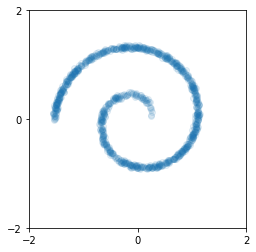

In [ ]:
# Make 8-bit swirl dataset
theta = np.sqrt(np.random.rand(N)) * 3 * np.pi  # np.linspace(0,2*pi,100)
r_a = 0.07 * (2 * theta + np.pi)
x = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
# We use 8 bits, to make this a bit similar to image data, which has 8-bit
# color channels.
x = x + 0.02 * np.random.randn(N, 2)

plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(x[:, 0], x[:, 1], alpha=0.1)
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

# Get mean and standard deviation of 'x'
x_mean = x.mean(axis=0)
x_std = x.std(axis=0)

# Noise schedule

In [ ]:
def gamma(t):
    b = init_gamma_0
    w = init_gamma_1 - init_gamma_0
    return w * t + b

# Plots of samples from q(z_t|x)

In [ ]:
# Create square plot:
def plot(data, fname=None, color="blue"):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xticks([-2, 0, 2])
    ax.set_yticks([-2, 0, 2])
    plt.scatter(data[:, 0], data[:, 1], alpha=0.1, c=color)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    if fname != None:
        plt.savefig(fname)
        files.download(fname)


def sample_q_t_x(rng, t, x):
    t *= jnp.ones((1,))
    var_t = nn.sigmoid(gamma(t))[:, None]
    eps = jax.random.normal(rng, shape=x.shape)
    z_t = jnp.sqrt(1.0 - var_t) * x + jnp.sqrt(var_t) * eps
    return z_t

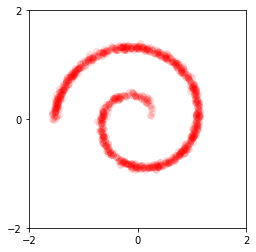

In [ ]:
rng, rng1 = jax.random.split(rng)
t = 0.0
plot(sample_q_t_x(rng1, t, x), None, color="red")

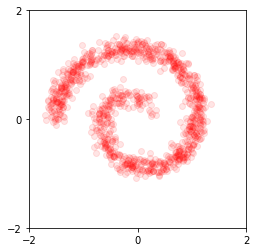

In [ ]:
rng, rng1 = jax.random.split(rng)
t = 0.25
plot(sample_q_t_x(rng1, t, x), None, color="red")

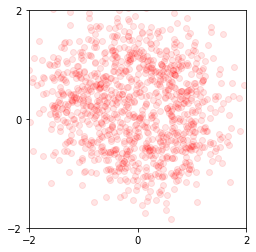

In [ ]:
rng, rng1 = jax.random.split(rng)
t = 0.5
plot(sample_q_t_x(rng1, t, x), None, color="red")

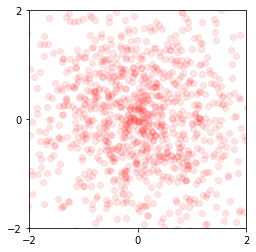

In [ ]:
rng, rng1 = jax.random.split(rng)
t = 1.0
plot(sample_q_t_x(rng, t, x), None, color="red")

# Log-density of q_t(z)

In [ ]:
def log_q_t_z(z, t):
    # t: scalar timestep
    # z: [B, D], points to evaluate on
    # x: [N, D], dataset
    # D: data dimensionality
    var_t = nn.sigmoid(gamma(t))[None, None, None]
    means_t = jnp.sqrt(1.0 - var_t) * x[None, :, :]

    log_q = (z[:, None, :] - means_t) ** 2 / var_t + jnp.log(var_t * 2 * jnp.pi)
    log_q *= -0.5
    log_q = log_q.sum(axis=2)

    # Mixture of Gaussians, N is number of mixture components
    N = x.shape[1]
    log_q = jax.scipy.special.logsumexp(log_q - jnp.log(N), axis=1)

    return log_q


def plot_density(t):
    k = 100
    _x = jnp.linspace(-2, 2, k)  # , endpoint=False)
    _y = jnp.linspace(-2, 2, k)  # , endpoint=False)
    xs, ys = jnp.meshgrid(_x, _y)
    xys = jnp.vstack([xs.ravel(), ys.ravel()]).T
    q_t_x = jnp.exp(log_q_t_z(xys, t))
    q_t_x = q_t_x.reshape((k, k))

    plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
    plt.contourf(_x, _y, q_t_x, 20, cmap="Greys")
    plt.xticks([-2, 0, 2])
    plt.yticks([-2, 0, 2])

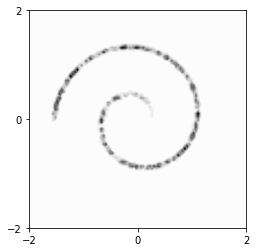

In [ ]:
plot_density(0.0)

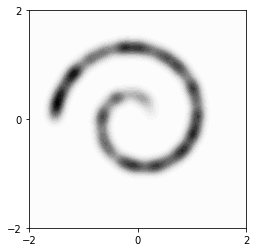

In [ ]:
plot_density(0.25)

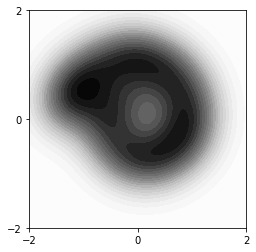

In [ ]:
plot_density(0.5)

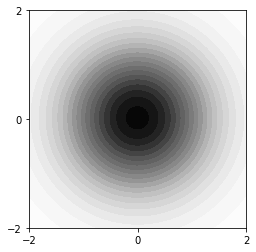

In [ ]:
plot_density(1.0)

# Plot scores of log q_t(x)

In [ ]:
def plot_quiver(f):
    k = 20
    _x = jnp.linspace(-2, 2, k)  # , endpoint=False)
    _y = jnp.linspace(-2, 2, k)  # , endpoint=False)
    xs, ys = jnp.meshgrid(_x, _y)
    xys = jnp.vstack([xs.ravel(), ys.ravel()]).T
    gradients = f(xys)

    plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
    plt.quiver(xys[:, 0], xys[:, 1], gradients[:, 0], gradients[:, 1], width=0.005)
    plt.xticks([-2, 0, 2])
    plt.yticks([-2, 0, 2])


f_score = jax.grad(lambda z, t: log_q_t_z(z, t).sum())

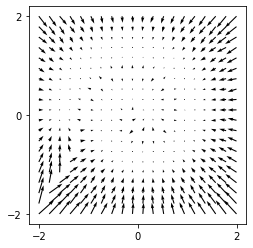

In [ ]:
plot_quiver(partial(f_score, t=0.0))

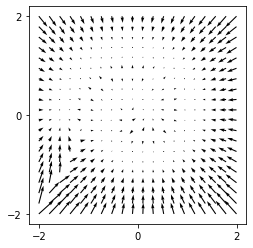

In [ ]:
plot_quiver(partial(f_score, t=0.25))

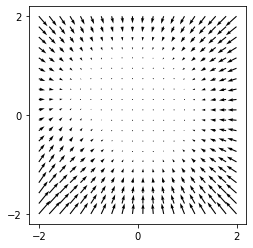

In [ ]:
plot_quiver(partial(f_score, t=0.5))

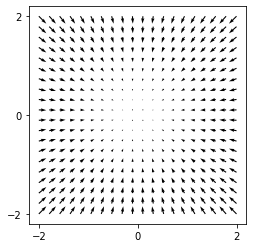

In [ ]:
plot_quiver(partial(f_score, t=1.0))